<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import Input

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [2]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [4]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


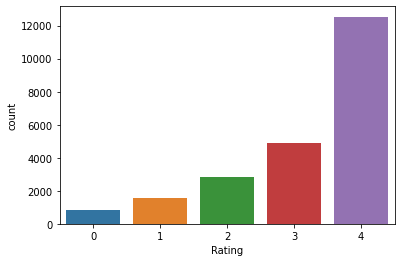

In [5]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
sns.countplot(x='Rating', data=df_reviews)
plt.show()

El dataset se encuentra fuertemente desbalanceado

In [6]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values

In [7]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
text_sequences.shape

(22641,)

In [8]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [9]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [10]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [11]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[0:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [12]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [13]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens) 

In [14]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [15]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [16]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

(array([ 123.,  704.,  920., 1274., 1474., 1292., 1598., 1570., 1204.,
        1461., 1372., 1064., 1162., 1138., 1121., 1922., 2055.,  944.,
         223.,   20.]),
 array([  2.  ,   7.65,  13.3 ,  18.95,  24.6 ,  30.25,  35.9 ,  41.55,
         47.2 ,  52.85,  58.5 ,  64.15,  69.8 ,  75.45,  81.1 ,  86.75,
         92.4 ,  98.05, 103.7 , 109.35, 115.  ]),
 <a list of 20 Patch objects>)

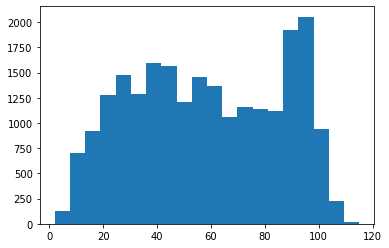

In [17]:
len_seq = [len(s) for s in sequences]
plt.hist(len_seq,bins=20)

In [18]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.preprocessing.sequence import pad_sequences
maxlen = 115

X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [19]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [20]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la máxima
# cantidad de palabras definidas para el vocabulario (vocab_size)
from sklearn.preprocessing import OneHotEncoder
y_encoder = OneHotEncoder(sparse= False)
y = y_encoder.fit_transform(df_reviews['Rating'].values.reshape(-1,1))

In [21]:
print(y.shape)

(22641, 5)


In [22]:
y[0:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [23]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y )

In [24]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # multi-class classification

### 2 - Entrenar el modelo con Embeddings + LSTM

#### Clasificación multi-clase utilizando fasttext embeddings

In [25]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Bidirectional

In [26]:
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Los embeddings fasttext.pkl ya están descargados


In [27]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [28]:
model_fasttext = FasttextEmbeddings()

In [29]:
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

In [30]:
!pip install tensorflow-addons

import tensorflow_addons as tfa 
f1_score = tfa.metrics.F1Score(out_shape,'macro')

In [31]:
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model1.add(LSTM(units=64, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=64))
model1.add(Dense(units=64, activation='relu'))
model1.add(Dropout(rate=0.2))
model1.add(Dense(units=out_shape, activation='softmax'))

model1.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_score])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 115, 300)          600000    
_________________________________________________________________
lstm (LSTM)                  (None, 115, 64)           93440     
_________________________________________________________________
dropout (Dropout)            (None, 115, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

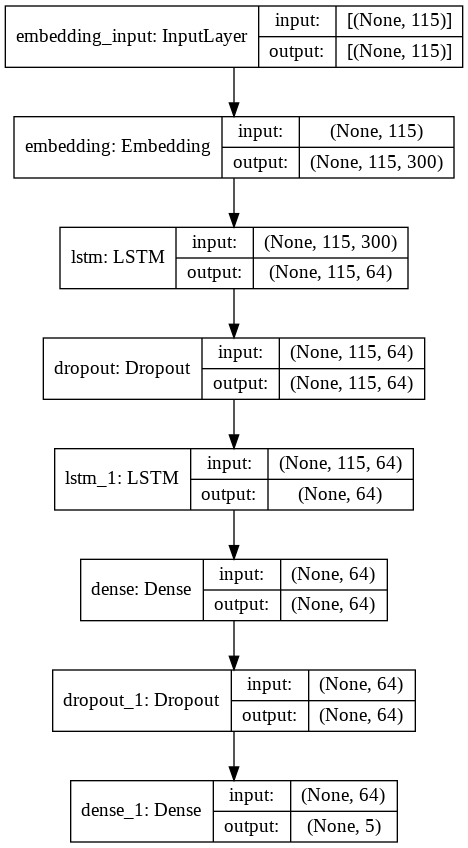

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
hist1 = model1.fit(X_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
453/453 [==============================] - 40s 59ms/step - loss: 1.2251 - accuracy: 0.5570 - f1_score: 0.1432 - val_loss: 1.2182 - val_accuracy: 0.5402 - val_f1_score: 0.1403
Epoch 2/30
453/453 [==============================] - 26s 57ms/step - loss: 1.1755 - accuracy: 0.5579 - f1_score: 0.1462 - val_loss: 1.1687 - val_accuracy: 0.5410 - val_f1_score: 0.1441
Epoch 3/30
453/453 [==============================] - 26s 57ms/step - loss: 1.1441 - accuracy: 0.5597 - f1_score: 0.1682 - val_loss: 1.1394 - val_accuracy: 0.5457 - val_f1_score: 0.1620
Epoch 4/30
453/453 [==============================] - 26s 57ms/step - loss: 1.1220 - accuracy: 0.5660 - f1_score: 0.1928 - val_loss: 1.1336 - val_accuracy: 0.5487 - val_f1_score: 0.1706
Epoch 5/30
453/453 [==============================] - 26s 58ms/step - loss: 1.0999 - accuracy: 0.5713 - f1_score: 0.2058 - val_loss: 1.1277 - val_accuracy: 0.5487 - val_f1_score: 0.1820
Epoch 6/30
453/453 [==============================] - 26s 58ms/step - 

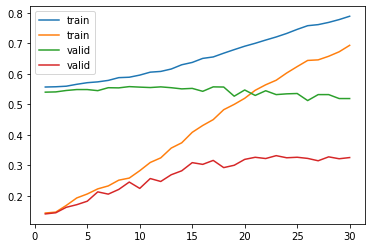

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist1.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist1.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist1.history['f1_score'], label='train')
sns.lineplot(x=epoch_count,  y=hist1.history['val_accuracy'], label='valid')
sns.lineplot(x=epoch_count,  y=hist1.history['val_f1_score'], label='valid')
plt.show()

In [35]:
model1.evaluate(X_test, y_test)

142/142 [==============================] - 3s 20ms/step - loss: 1.7669 - accuracy: 0.5308 - f1_score: 0.3169


[1.7669169902801514, 0.5308014750480652, 0.3169373571872711]

Observamos que el modelo tiene la complejidad suficiente para el problema, pero tenemos un gran overfitting. Se concluye que hacen falta mas reviews para obtener mejores resultados, espcialmente para balancear el dataset.

#### Clasificación binaria. Dividimos el dataset entre clasificación máxima (5 estrellas) y el resto para obtener un dataset mas balanceado

In [36]:
y_train2=y_train[:,4]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


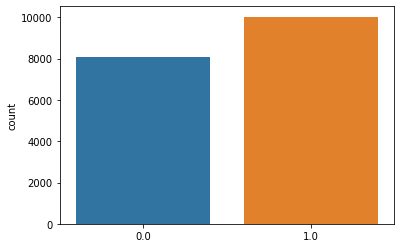

In [37]:
sns.countplot(y_train2)
plt.show()

In [38]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64))
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=1, activation='sigmoid'))

model2.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 115, 300)          600000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 115, 64)           93440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 115, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

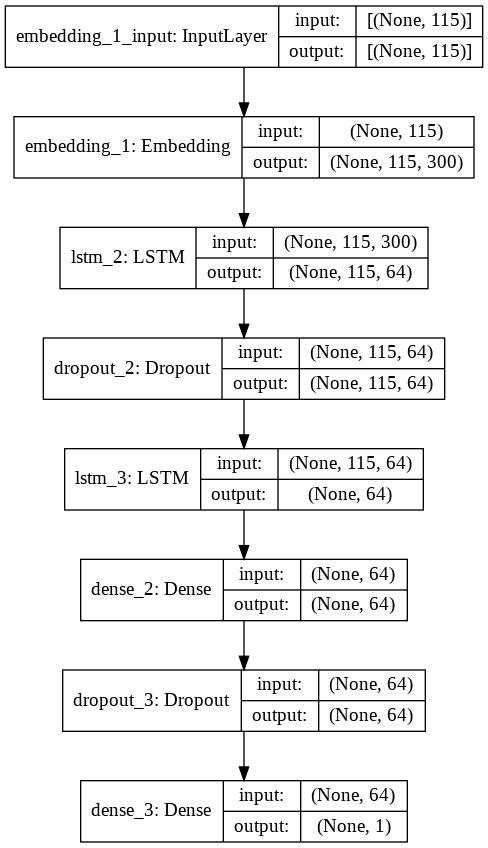

In [39]:
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
hist2 = model2.fit(X_train, y_train2, epochs=30, validation_split=0.2)

Epoch 1/30
453/453 [==============================] - 31s 59ms/step - loss: 0.6745 - accuracy: 0.5793 - val_loss: 0.6541 - val_accuracy: 0.6144
Epoch 2/30
453/453 [==============================] - 25s 56ms/step - loss: 0.6481 - accuracy: 0.6186 - val_loss: 0.6458 - val_accuracy: 0.6219
Epoch 3/30
453/453 [==============================] - 25s 56ms/step - loss: 0.6300 - accuracy: 0.6471 - val_loss: 0.6219 - val_accuracy: 0.6600
Epoch 4/30
453/453 [==============================] - 25s 56ms/step - loss: 0.6126 - accuracy: 0.6679 - val_loss: 0.6173 - val_accuracy: 0.6580
Epoch 5/30
453/453 [==============================] - 25s 56ms/step - loss: 0.5961 - accuracy: 0.6869 - val_loss: 0.5957 - val_accuracy: 0.6892
Epoch 6/30
453/453 [==============================] - 25s 56ms/step - loss: 0.5818 - accuracy: 0.6945 - val_loss: 0.5967 - val_accuracy: 0.6820
Epoch 7/30
453/453 [==============================] - 25s 56ms/step - loss: 0.5645 - accuracy: 0.7111 - val_loss: 0.5895 - val_accuracy:

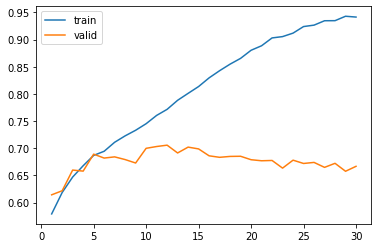

In [41]:
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [42]:
y_test2=y_test[:,4]

In [43]:
model2.evaluate(X_test, y_test2)

142/142 [==============================] - 3s 19ms/step - loss: 1.2670 - accuracy: 0.6697


[1.2669990062713623, 0.6696842312812805]

En este caso obtuvimos mejores métricas pero aún se evidencia la presencia de overfitting

#### Redes LSTM paralelas especializadas

In [44]:
def model3_make_model():
  input_layer = Input(in_shape)
  embed_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                      weights=[embedding_matrix], trainable=False)(input_layer)

  lstm1_layer = LSTM(units=64)(embed_layer)
  drop1_layer = Dropout(0.2)(lstm1_layer)
  out1_layer = Dense(units=1, activation='sigmoid')(drop1_layer)


  lstm2_layer = LSTM(units=64)(embed_layer)
  drop2_layer = Dropout(0.2)(lstm2_layer)
  out2_layer = Dense(units=1, activation='sigmoid')(drop2_layer)

  lstm3_layer = LSTM(units=64)(embed_layer)
  drop3_layer = Dropout(0.2)(lstm3_layer)
  out3_layer = Dense(units=1, activation='sigmoid')(drop3_layer)


  lstm4_layer = LSTM(units=64)(embed_layer)
  drop4_layer = Dropout(0.2)(lstm4_layer)
  out4_layer = Dense(units=1, activation='sigmoid')(drop4_layer)


  lstm5_layer = LSTM(units=64)(embed_layer)
  drop5_layer = Dropout(0.2)(lstm5_layer)
  out5_layer = Dense(units=1, activation='sigmoid')(drop5_layer)

  concat_layer =  Concatenate()([out1_layer,out2_layer,out3_layer,out4_layer,out5_layer])
  

  model = Model(input_layer, concat_layer)

  return model


In [45]:
model3 = model3_make_model()

model3.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 115)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 115, 300)     600000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 64)           93440       embedding_2[0][0]                
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 64)           93440       embedding_2[0][0]                
______________________________________________________________________________________________

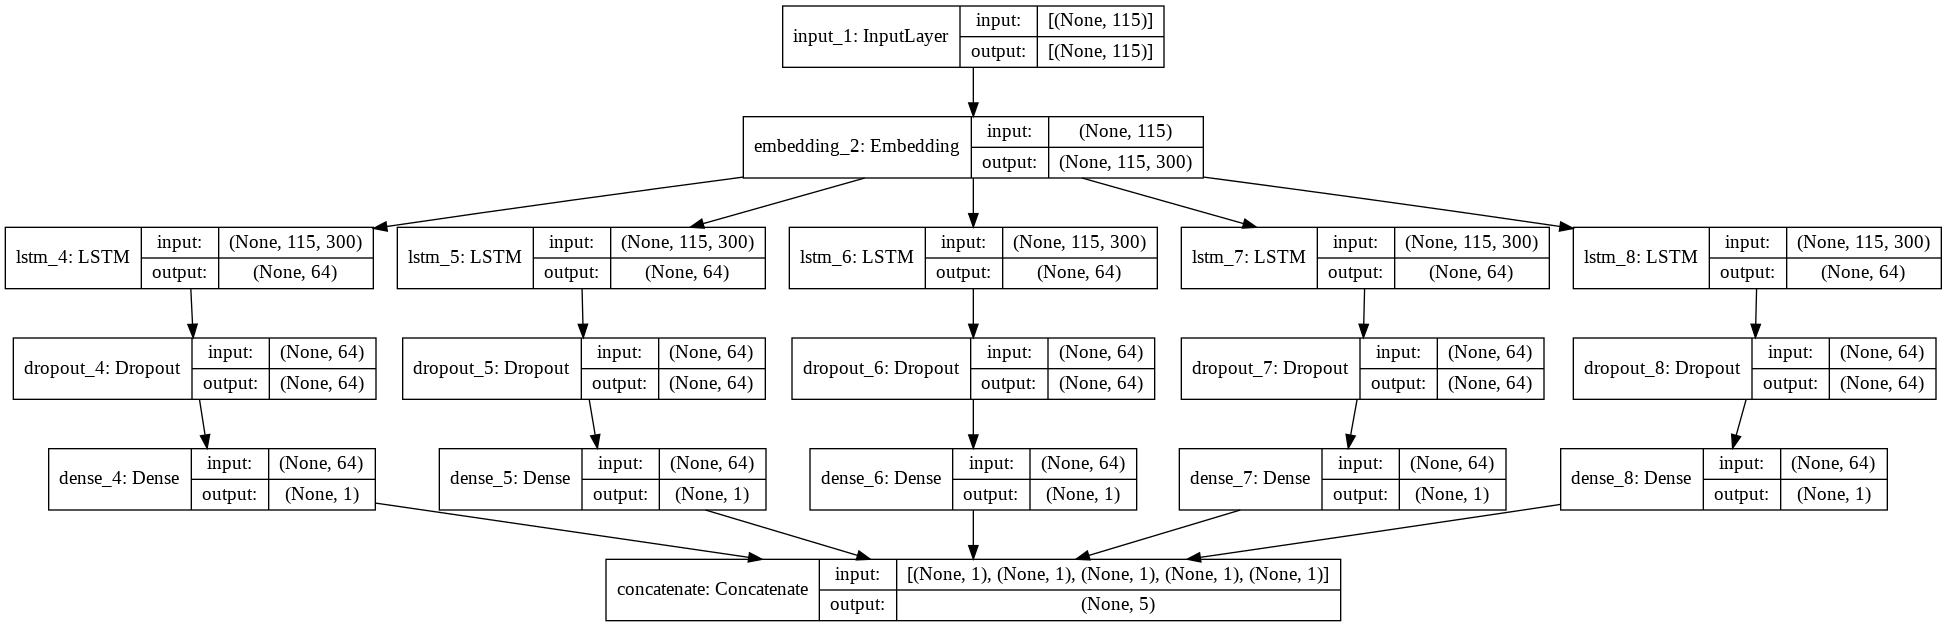

In [46]:
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [47]:
hist3 = model3.fit(X_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
453/453 [==============================] - 80s 155ms/step - loss: 0.3978 - accuracy: 0.5559 - val_loss: 0.3968 - val_accuracy: 0.5402
Epoch 2/30
453/453 [==============================] - 68s 149ms/step - loss: 0.3887 - accuracy: 0.5571 - val_loss: 0.3916 - val_accuracy: 0.5421
Epoch 3/30
453/453 [==============================] - 68s 151ms/step - loss: 0.3835 - accuracy: 0.5578 - val_loss: 0.3888 - val_accuracy: 0.5424
Epoch 4/30
453/453 [==============================] - 68s 151ms/step - loss: 0.3785 - accuracy: 0.5625 - val_loss: 0.3861 - val_accuracy: 0.5471
Epoch 5/30
453/453 [==============================] - 68s 151ms/step - loss: 0.3734 - accuracy: 0.5641 - val_loss: 0.3797 - val_accuracy: 0.5468
Epoch 6/30
453/453 [==============================] - 68s 151ms/step - loss: 0.3676 - accuracy: 0.5700 - val_loss: 0.3770 - val_accuracy: 0.5506
Epoch 7/30
453/453 [==============================] - 68s 150ms/step - loss: 0.3622 - accuracy: 0.5764 - val_loss: 0.3724 - val_ac

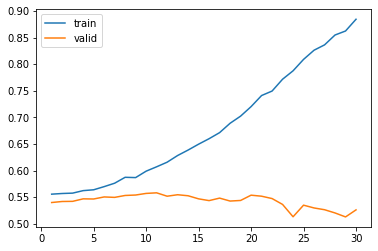

In [48]:
epoch_count = range(1, len(hist3.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist3.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist3.history['val_accuracy'], label='valid')
plt.show()

In [49]:
model3.evaluate(X_test, y_test)

142/142 [==============================] - 8s 59ms/step - loss: 0.5834 - accuracy: 0.5273


[0.5834462642669678, 0.5272687077522278]

Este caso fue el peor de todos en términos de overfitting